In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/研究所/Pytorch與機器學習/期末報告"

In [ ]:
#cuda不用重新自己找，這個就有了 謝謝呆QQ
# !conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [ ]:
# %cd "D:\研究所\110-1\Pytorch與機器學習\期末報告\C1-P1_Train Dev"
%cd "C:\Users\user\Desktop\110356021\期末報告" 

#/C1-P1_Train 
#/C1-P1_Dev 

C:\Users\user\Desktop\110356021\期末報告


In [ ]:
# !pip install tensorflow

In [ ]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #指定第二張顯卡
import cv2 #pip install opencv-python
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import torchvision
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf

PADDING_SIZE = 1536
IMG_SHAPE = (224,224)
OUTPUT_CLASSES = 3
dtype = torch.float32
MEAN = [55.49694383, 60.2820865, 82.53554147]
STD = [65.72940478, 67.66902771, 87.42390442]

C:\Users\user\anaconda3\envs\test\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\user\anaconda3\envs\test\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# img = cv2.imread("./C1-P1_Train/00003.jpg") #type = numpy.ndarray
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# print(img.shape)

[PyTorch (DataLoader & Alexnet & Resnet)](https://www.kaggle.com/kowshirbitto/pytorch-dataloader-alexnet-resnet)

https://pytorch.org/vision/stable/transforms.html

https://zhuanlan.zhihu.com/p/53367135

https://blog.csdn.net/sinat_28375239/article/details/108256232

In [ ]:
#前n筆資料，若-1則所有資料
data_num = -1

In [ ]:
def get_pad_seq(img, PADDING_SIZE=1536):
    '''
    input : (H,W,C) numpy array
    output : (dim_0,dim_1) numpy array

    若PIL.shape = (1008, 1344, 3)，要pad成 torch.Size([3, 2000, 2000])
    transform.Pad(pad_seq), pad_seq.shape = (pad_dim_0, pad_dim_1)

    1.維度0,1的直觀表示順序是相反的，要注意(寫得有點難懂，先不確認正確性了 哈哈)
      PIL_padded[0] = PIL.shape[1] + 2*pad_dim_1
      PIL_padded[1] = PIL.shape[0] + 2*pad_dim_0

    2.不須特別先轉成(3,1008,1344)即可直接套用
    max_hw 可以 更好的命名為PADDING_SIZE
    '''
    temp = np.asarray(img)
    assert temp.shape[0] % 2 != 0 or temp.shape[1] % 2 == 0, f'維度有奇數, shape = {temp.shape}'

    pad_dim_1 = int((PADDING_SIZE - temp.shape[0])/2) 
    pad_dim_0 = int((PADDING_SIZE - temp.shape[1])/2) 

    if pad_dim_0 % 2 == 0 and pad_dim_1 % 2 == 0:
        pad_seq = (pad_dim_0,pad_dim_1)

    #維度有奇數的計算
    # elif dim_0 % 2 != 0:
    #     pad_seq = (dim_0,dim_0+1,dim_1,dim_1)
    # elif dim_1 % 2 != 0:
    #     pad_seq = (dim_0,dim_0,dim_1,dim_1+1)   

    return pad_seq


In [ ]:
def x_Pipeline(img, PADDING_SIZE=1536, IMG_SHAPE = 224):


    pad_seq = get_pad_seq(img, PADDING_SIZE) #1536x1536

    preprocess = transforms.Compose([
    transforms.Pad(pad_seq), #padding
    transforms.Resize(IMG_SHAPE), #resizing
    #transforms.CenterCrop(224), #Crop
    transforms.ToTensor() #會自動/255
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalizing
    ]) #Normalize的mean, std要依據R,G,B三個channel做計算
    
    img = preprocess(img)

    return img
# x_train = x_Pipeline(train_img, PADDING_SIZE=1536, IMG_SHAPE[0])
# x_test = x_Pipeline(dev_img, PADDING_SIZE=1536, IMG_SHAPE[0])

In [ ]:
def read_data(which='train', file_num=1e5):
    drc_path = None
    y = None
    if which == "train":
        drc_path = "C1-P1_Train"
        label_csv = "train.csv"
    elif which == "test":
        drc_path = "C1-P1_Dev"
        label_csv = "dev.csv"
    else:
        print("input should be train or test")
        return 
    x = []
    y = pd.get_dummies(pd.read_csv(label_csv, header=None)[1].to_numpy())

    filenames = sorted(os.listdir(drc_path))

    file_cnt = 0
    for filename in tqdm(filenames):
        fpath = os.path.join(drc_path, filename)
        img = Image.open(fpath)
        img = x_Pipeline(img, PADDING_SIZE, IMG_SHAPE)
        plt.imshow(np.uint8(img*255).transpose(1,2,0)) #permute(torch) 同等效力於 transpose(numpy)
        x.append(img.detach().numpy()) #tensor to numpy  #.detach().numpy()

        file_cnt += 1
        if file_cnt >= file_num:
            break
        
    x = np.asarray(x)
    print(f'x.shape={x.shape}\ny.shape={y.shape}')
    return x, y

In [ ]:
%%time

# x_train, y_train = read_data(which="train")
# x_test, y_test = read_data(which="test")

npy_dir = "./npy_file"

x_train = np.load(os.path.join(npy_dir, "x_train.npy"))
y_train = np.load(os.path.join(npy_dir, "y_train.npy"))
x_test = np.load(os.path.join(npy_dir, "x_test.npy"))
y_test = np.load(os.path.join(npy_dir, "y_test.npy"))


Wall time: 10.4 s


In [ ]:
# npy_dir = "../npy_file"
# np.save(os.path.join(npy_dir, "x_train.npy"), x_train)
# np.save(os.path.join(npy_dir, "y_train.npy"), y_train)
# np.save(os.path.join(npy_dir, "x_test.npy"), x_test)
# np.save(os.path.join(npy_dir, "y_test.npy"), y_test)

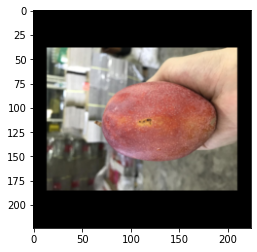

In [ ]:
#cv2_imshow((x_train[0]*255).transpose(1,2,0))
#Q:不懂為啥秀圖片像是除了255兩次，function中的只要回乘255一次，外部呼叫要回乘255兩次
#A:因為transforms.ToTensor()會先自動/255
pil_image=Image.fromarray(np.uint8(x_train[2]*255).transpose(1,2,0)) 
plt.imshow(pil_image)

In [ ]:
print(len(x_train))
print(x_train.shape)

5600
(5600, 3, 224, 224)


In [ ]:
#小呆多算出來的STD, MEAN
MEAN = [55.49694383, 60.2820865, 82.53554147]
STD = [65.72940478, 67.66902771, 87.42390442]

In [ ]:
# from google.colab.patches import cv2_imshow

# for i, img in enumerate(x_train[:3]):
#     print(f"第{i+1}張圖片:")
#     img = cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB)
#     cv2_imshow((img*255))  #cv2_imshow(img*STD+MEAN)  

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
x_train.shape

(5040, 3, 224, 224)

In [ ]:
#Data augmentation From 小呆
# 小呆(2021) indicated that ColorJitter should be used carefully, cuz the red color belongs to a better mango.
data_aug = [
  transforms.RandomCrop((200, 200)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomAffine(degrees=50, translate=(0.15, 0.15), scale=(0.8, 1)),
  #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #
]

transform_aug = transforms.Compose([
  transforms.RandomOrder(data_aug),
])

In [ ]:
import torch 
from torch.utils.data import Dataset,DataLoader

class MangoDataset(Dataset):
    def __init__(self, x, y, transform_aug=None):

        self.x = x
        self.y = torch.tensor(y)
        self.transform_aug = transform_aug

    def __getitem__(self,idx):
        
        image =  self.x[idx]
        #image = image[:,:,::-1] #.transpose(2,0,1)
        image = torch.tensor(image.copy(), dtype=dtype)
        label = self.y[idx]
        if self.transform_aug:
            image = self.transform_aug(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.y)


In [ ]:
x_train.shape

(5040, 3, 224, 224)

In [ ]:
BATCH_SIZE = 64
train_dataset = MangoDataset(x_train, y_train, transform_aug=transform_aug)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  #My Local PC support only 0 num_workers

val_dataset = MangoDataset(x_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dataset = MangoDataset(x_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
print(torch.cuda.is_available())
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


#### Resnet 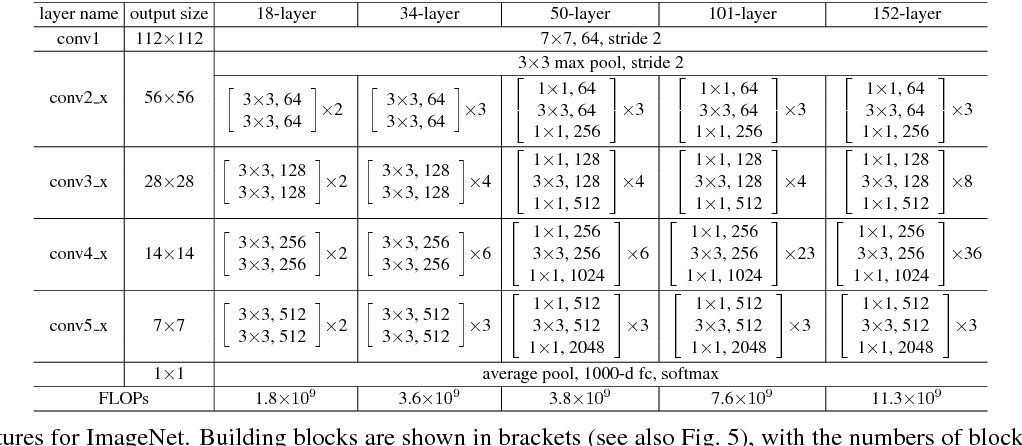


In [ ]:
def setting_model(model, resnet, freeze_pretrained=False): 

    
    if resnet == "resnet18" or resnet == "resnet34":
        fc_shape = (512,256,256,3)
    elif resnet == "resnet50" or resnet == "resnet101" or  resnet == "resnet152":
        fc_shape = (2048,512,512,3)

    # Freeze the pretrained weight 
    if freeze_pretrained:
        for p in model.parameters():
            p.requires_grad = False
    # Define the Fully connected layer
    new_fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=fc_shape[0], out_features=fc_shape[1], bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=fc_shape[2], out_features=fc_shape[3], bias=True)
        )
    # Deploy the fc layer
    model.fc = new_fc

    # Deploy the model in GPU
    model_cuda = model.cuda()

    return model_cuda

def count_parameters(model):
  trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
  non_trainable_p = sum(p.numel() for p in model.parameters() if not p.requires_grad)
  return trainable_p, non_trainable_p

def cal_acc(outputs, label):
    y_score = torch.argmax(outputs,axis=1)
    y_true = torch.argmax(label,axis=1)
    correct = (y_score == y_true).float().sum()
    accuracy = correct / len(y_true)
    return float(accuracy)

def validation(model, loader):
  num_correct = 0
  num_samples = 0
  loss = 0.0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y_true = y.to(device=device, dtype=dtype).argmax(axis=1)
      scores = model(x)      
      _, preds = scores.max(1)
      num = preds.size(0)
      loss += loss_fn(scores, y_true) * num
      
      num_correct += (preds == y_true).sum()
      num_samples += num
    acc = float(num_correct) / num_samples
    loss = float(loss / num_samples)
    return acc, loss
    # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def softmax(x):
    
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def make_confusion_matrix(y_true, y_score):

    cm = confusion_matrix(y_true, y_score)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C']) #
    disp.plot()

    return cm

from sklearn.metrics import roc_curve, auc 

#https://ppfocus.com/0/te0aa36ce.html
def plot_roc(y_true,  y_score, n_classes): #multiclass ROC curve
    """
    compute ROC curve and ROC area for each class in each fold

    """

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plt.figure(figsize=(6,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.tight_layout()
    plt.show()

def plot_loss(checkpoint):
    plt.plot([i.cpu().detach() for i in checkpoint['train_loss_history']], label = 'train') 
    plt.plot(checkpoint['val_loss_history'], label = "val") 
    plt.title("Training / Val loss history")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

def plot_acc(checkpoint):
    plt.plot(checkpoint['train_acc_history'], label = "train")
    plt.plot(checkpoint['val_acc_history'], label = "val")
    plt.title("Training / Val Acc history")
    plt.xlabel("Epoch") # 這裡應該要是epoch
    plt.ylabel("Acc")
    plt.grid(linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()


Deploy the network

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
model = models.resnet50(pretrained=True)
model_name = "resnet50"
model = setting_model(model, resnet=model_name) #fc_shape is different based on which model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn= torch.nn.CrossEntropyLoss()

Count the parameters of network

In [ ]:
t_p, n_t_p = count_parameters(model)

print('# of parameters')
trainable_p, non_trainable_p = count_parameters(model)
print('trainable:     %15s' % format(trainable_p, ','))
print('non-trainable: %15s' % (format(non_trainable_p, ',')))

# of parameters
trainable:          24,558,659
non-trainable:               0


Train the network

In [ ]:
checkpoint = {
    "model_pre" : model,
    "model_post" : None,
    "optimizer" : optimizer,
    "loss function" : loss_fn,
    "BATCH_SIZE" : BATCH_SIZE,
    "epoch" : None,
    "train_loss_history" : [],
    "val_loss_history" : [],
    "train_acc_history" : [],
    "val_acc_history" : [],
    "test_acc" : None,
    "y_score" : None,
    "y_true" : None
}

In [ ]:
#記憶體不足
epochs = 30
checkpoint['epoch'] = epochs
checkpoint['model_name'] = model_name

for e in range(epochs):
    print(f"Epoch {e}")
    n_batches = len(train_dataloader)
    pbar = tf.keras.utils.Progbar(target=n_batches)
    for i, (data, label) in tqdm(enumerate(train_dataloader)):
        data = data.to(device, dtype=dtype)
        label = label.to(device, dtype=dtype)
        outputs = model(data)
        loss = loss_fn(outputs, label) 
        accuracy = cal_acc(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update(i, values=[("train_loss", float(loss)),
            ("train_acc", accuracy)])
        
    checkpoint['train_loss_history'].append(loss)
    checkpoint['train_acc_history'].append(accuracy)
        
    val_acc, val_loss = validation(model, val_dataloader)
    pbar.update(n_batches, values=[('val_loss', val_loss), ('val_acc', val_acc)])
    checkpoint['val_loss_history'].append(val_loss)
    checkpoint['val_acc_history'].append(val_acc)
    
checkpoint['model_post'] = model

Epoch 0


0it [00:00, ?it/s]

79/79 [==============================] - 57s 679ms/step - train_loss: 0.6814 - train_acc: 0.6938 - val_loss: 0.5529 - val_acc: 0.7589
Epoch 1


0it [00:00, ?it/s]

79/79 [==============================] - 52s 653ms/step - train_loss: 0.6398 - train_acc: 0.7184 - val_loss: 0.5474 - val_acc: 0.7393
Epoch 2


0it [00:00, ?it/s]

79/79 [==============================] - 54s 669ms/step - train_loss: 0.5976 - train_acc: 0.7353 - val_loss: 0.5754 - val_acc: 0.7750
Epoch 3


0it [00:00, ?it/s]

79/79 [==============================] - 55s 681ms/step - train_loss: 0.5907 - train_acc: 0.7389 - val_loss: 0.5630 - val_acc: 0.7411
Epoch 4


0it [00:00, ?it/s]

79/79 [==============================] - 55s 685ms/step - train_loss: 0.5776 - train_acc: 0.7491 - val_loss: 0.5647 - val_acc: 0.7482
Epoch 5


0it [00:00, ?it/s]

79/79 [==============================] - 54s 673ms/step - train_loss: 0.5452 - train_acc: 0.7634 - val_loss: 0.5171 - val_acc: 0.7821
Epoch 6


0it [00:00, ?it/s]

79/79 [==============================] - 53s 665ms/step - train_loss: 0.5614 - train_acc: 0.7476 - val_loss: 0.5436 - val_acc: 0.7732
Epoch 7


0it [00:00, ?it/s]

79/79 [==============================] - 54s 670ms/step - train_loss: 0.5307 - train_acc: 0.7697 - val_loss: 0.5623 - val_acc: 0.7768
Epoch 8


0it [00:00, ?it/s]

79/79 [==============================] - 54s 677ms/step - train_loss: 0.5188 - train_acc: 0.7712 - val_loss: 0.5090 - val_acc: 0.7839
Epoch 9


0it [00:00, ?it/s]

79/79 [==============================] - 54s 676ms/step - train_loss: 0.5097 - train_acc: 0.7634 - val_loss: 0.5378 - val_acc: 0.7911
Epoch 10


0it [00:00, ?it/s]

79/79 [==============================] - 53s 668ms/step - train_loss: 0.4956 - train_acc: 0.7855 - val_loss: 0.5105 - val_acc: 0.7732
Epoch 11


0it [00:00, ?it/s]

79/79 [==============================] - 52s 652ms/step - train_loss: 0.4956 - train_acc: 0.7740 - val_loss: 0.5655 - val_acc: 0.7714
Epoch 12


0it [00:00, ?it/s]

79/79 [==============================] - 53s 665ms/step - train_loss: 0.4803 - train_acc: 0.7929 - val_loss: 0.5159 - val_acc: 0.7857
Epoch 13


0it [00:00, ?it/s]

79/79 [==============================] - 53s 662ms/step - train_loss: 0.4763 - train_acc: 0.7854 - val_loss: 0.5670 - val_acc: 0.7679
Epoch 14


0it [00:00, ?it/s]

79/79 [==============================] - 54s 673ms/step - train_loss: 0.4749 - train_acc: 0.7849 - val_loss: 0.5144 - val_acc: 0.7857
Epoch 15


0it [00:00, ?it/s]

79/79 [==============================] - 53s 664ms/step - train_loss: 0.4576 - train_acc: 0.8026 - val_loss: 0.5575 - val_acc: 0.7643
Epoch 16


0it [00:00, ?it/s]

79/79 [==============================] - 53s 656ms/step - train_loss: 0.4505 - train_acc: 0.8049 - val_loss: 0.5781 - val_acc: 0.7482
Epoch 17


0it [00:00, ?it/s]

79/79 [==============================] - 53s 660ms/step - train_loss: 0.4479 - train_acc: 0.8008 - val_loss: 0.6363 - val_acc: 0.7714
Epoch 18


0it [00:00, ?it/s]

79/79 [==============================] - 54s 676ms/step - train_loss: 0.4476 - train_acc: 0.8100 - val_loss: 0.5484 - val_acc: 0.7500
Epoch 19


0it [00:00, ?it/s]

79/79 [==============================] - 54s 672ms/step - train_loss: 0.4416 - train_acc: 0.8050 - val_loss: 0.5761 - val_acc: 0.7536
Epoch 20


0it [00:00, ?it/s]

79/79 [==============================] - 54s 674ms/step - train_loss: 0.4445 - train_acc: 0.8043 - val_loss: 0.4969 - val_acc: 0.7893
Epoch 21


0it [00:00, ?it/s]

79/79 [==============================] - 53s 664ms/step - train_loss: 0.4127 - train_acc: 0.8182 - val_loss: 0.5152 - val_acc: 0.7804
Epoch 22


0it [00:00, ?it/s]

79/79 [==============================] - 53s 663ms/step - train_loss: 0.4089 - train_acc: 0.8261 - val_loss: 0.5116 - val_acc: 0.8036
Epoch 23


0it [00:00, ?it/s]

79/79 [==============================] - 52s 655ms/step - train_loss: 0.3959 - train_acc: 0.8285 - val_loss: 0.5249 - val_acc: 0.7786
Epoch 24


0it [00:00, ?it/s]

79/79 [==============================] - 54s 679ms/step - train_loss: 0.4029 - train_acc: 0.8263 - val_loss: 0.5106 - val_acc: 0.7857
Epoch 25


0it [00:00, ?it/s]

79/79 [==============================] - 59s 739ms/step - train_loss: 0.3751 - train_acc: 0.8365 - val_loss: 0.5346 - val_acc: 0.7821
Epoch 26


0it [00:00, ?it/s]

79/79 [==============================] - 60s 745ms/step - train_loss: 0.3766 - train_acc: 0.8314 - val_loss: 0.6509 - val_acc: 0.7661
Epoch 27


0it [00:00, ?it/s]

79/79 [==============================] - 60s 748ms/step - train_loss: 0.3787 - train_acc: 0.8372 - val_loss: 0.5762 - val_acc: 0.7768
Epoch 28


0it [00:00, ?it/s]

79/79 [==============================] - 60s 756ms/step - train_loss: 0.3644 - train_acc: 0.8483 - val_loss: 0.5124 - val_acc: 0.7732
Epoch 29


0it [00:00, ?it/s]

79/79 [==============================] - 60s 749ms/step - train_loss: 0.3667 - train_acc: 0.8420 - val_loss: 0.6437 - val_acc: 0.7750


train_loss, val_loss放一張圖

train_acc, val_acc放一張圖

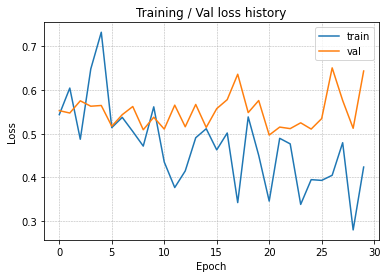

In [ ]:
plot_loss(checkpoint)

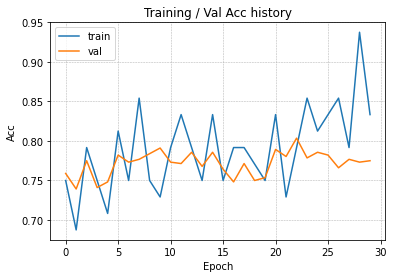

In [ ]:
plot_acc(checkpoint)

In [ ]:
test_dataset = MangoDataset(x_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=5, shuffle=True, num_workers=0)

Test the network

In [ ]:
test_acc = 0
pbar = tf.keras.utils.Progbar(target=n_batches)
y_score = []
y_true = []
accuracies = []
for i, (data, label) in tqdm(enumerate(test_dataloader)):
    data = data.to(device, dtype=dtype)
    label = label.to(device, dtype=dtype)
    outputs = model(data)
    loss = loss_fn(outputs, label) 
    accuracy = cal_acc(outputs, label)

    pbar.update(i, values=[("test_loss", float(loss)),
    ("test_acc", accuracy)])

    y_score.extend(outputs.cpu().detach().numpy())
    y_true.extend(label.cpu().detach().numpy())

    accuracies.append(accuracy)

checkpoint['test_acc'] = np.mean(accuracies)

#Use to do the metrics below
y_score = np.asarray(y_score)
y_true = np.asarray(y_true)

checkpoint['y_score'] = y_score
checkpoint['y_true'] = y_true

print(f"\nTest Accuracy = {checkpoint['test_acc']}")

0it [00:00, ?it/s]

159/79 [============================================================] - 3s 18ms/step - test_loss: 0.5995 - test_acc: 0.7663

Test Accuracy = 0.7662500105798244


### Save / Load the checkpoint

In [ ]:
# 先存起來 可直接call來寫下面程式
# npy_dir = "../npy_file"
# np.save(os.path.join(npy_dir, "y_score.npy"), y_score)
# np.save(os.path.join(npy_dir, "y_true.npy"), y_true)

# y_score = np.load(os.path.join(npy_dir, "y_score.npy"))
# y_true = np.load(os.path.join(npy_dir, "y_true.npy"))

import pickle

filepath = "./checkpoints" #'../checkpoints'
if os.path.isdir(filepath) == False: 
    os.mkdir(filepath)

filename = f"{checkpoint['model_name']}_{checkpoint['test_acc']}.pkl"
with open (f"./checkpoints/{filename}", "wb") as f:
    pickle.dump(checkpoint, f)


讀取checkpoints

https://colab.research.google.com/drive/1cYkbIzqdClrwzcmrnS2pOsn0TsyVGCYQ?usp=sharing

In [ ]:
drc_path = "./checkpoints/"
filenames = sorted(os.listdir(drc_path))
checkpoints = {}
for filename in (filenames):
    print(filename)
    with open(drc_path + filename, 'rb') as f:
      checkpoints[filename] = pickle.load(f)
print(f'已讀取{len(filenames)}筆checkpoints')

resnet18_0.7680288461538461.pkl
resnet34_0.7752403846153846.pkl
resnet50_0.7662500105798244.pkl
已讀取3筆checkpoints


### Metrics

Calculate the y_true and y_score into the form of answer-index only

In [ ]:
y_true_argmax = np.argmax(y_true, axis=1)
y_score_argmax = np.argmax(y_score, axis=1)

Visualize the confusion matrix

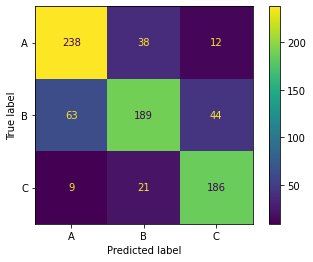

In [ ]:
cm = make_confusion_matrix(y_true_argmax, y_score_argmax)

Calculate the Multiclass precision, recall, f1 score

In [ ]:
# Multiclass Precision, Recall, F1-score
from sklearn import metrics
# Print the confusion matrix
# print(metrics.confusion_matrix(y_true_str, y_score_str))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true_argmax, y_score_argmax, digits=3, target_names=["A","B","C"]))

              precision    recall  f1-score   support

           A      0.768     0.826     0.796       288
           B      0.762     0.639     0.695       296
           C      0.769     0.861     0.812       216

    accuracy                          0.766       800
   macro avg      0.766     0.775     0.768       800
weighted avg      0.766     0.766     0.763       800



Visualize the ROC curve and AUC

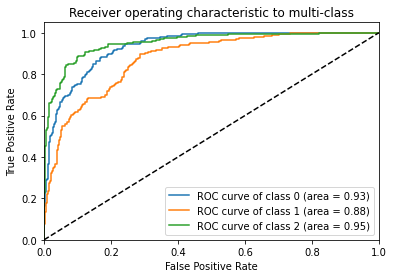

In [ ]:
y_score_softmax = softmax(y_score)
plot_roc(y_true,  y_score_softmax, 3)

###紀錄

###2021/12/5 

1.起初是想直接寫一個padding函數，把所有圖片設定相同大小。發現可以透過torchvision的Compose直接定義Pipeline後，想說可以用transform.pad來做前面那件事，但是計算pad_seq要透過np.array input。transform的input要PIL，所以迴圈內有點尷尬。

目前考慮先蒐集PIL，讓transform的Pipeline可以順利，計算pad_seq的函數重新調整程適合的方式。

###2021/12/6

成功建立PIL的預處理Pipeline

1.   確認模型後，調整Resize大小
2.   Crop屬於Data augmentation的部分

1.   label one-hot encoding, validation set還沒處理
2.   Normalization還沒看怎麼用(done by dividing by 255)

記憶體不足以一次處理完所有資料
要批次做處理

dataset, dataloader



###2021/12/08

省去了將未處理圖片存進list的步驟，直接讀取並做處理再存進numpy array，numpy array會變成一維，所以要再reshape(data_num, 3, max_hw, max_hw)。

成功透過Dataset, DataLoader將資料儲存並呼叫，DataLoader支援用batch_size批次呼叫資料。

成功分割出x_train, x_val, y_train, y_val。

###2021/12/09 討論



1.   分享資料預處理手法
2.   討論記憶體問題

1.   模型選用分配
2.   List item












In [ ]:
# def read_drc(drc_path, data_num):
#     img_arr = []
#     file_cnt = 0
#     for filename in os.listdir(drc_path):
#         file_cnt += 1
#         img = np.array(Image.open(f'{drc_path}/{filename}'), dtype=np.int32)
#         img = img.reshape(1,3,img.shape[0], img.shape[1])
#         img_arr.append(img)
#         if file_cnt >= data_num:
#             break
#     print(f'img_arr[0].shape = {img_arr[0].shape}')
#     return img_arr
# train_img = read_drc("C1-P1_Train", data_num = 10) #存放numpy array的list
# dev_img = read_drc("C1-P1_Dev", data_num = 5)

#裁剪圖像
#Select first 128 pixels of the image 
#image_cropped = image[:,:128] 
#Show image plt.imshow(image_cropped, cmap='gray')
#plt.axis('off') 
#plt.show()

#調整圖像大小
#Resizing the image to 50x50 pixels 
#image_50x50 = cv2.resize(image, (50, 50))
#plt.imshow(image_50x50, cmap='gray')
#plt.axis('off')
#plt.show()


# def read_PIL(drc_path, data_num):
#     """
#     input : 資料夾目錄, 資料數量
#     output : Image的list

#     """
#     img_PIL = []
#     file_cnt = 0
#     for filename in os.listdir(drc_path):
#         #print(filename)
#         file_cnt += 1
#         img = Image.open(f'{drc_path}/{filename}')
#         img_PIL.append(img)
#         if data_num == -1:
#             continue
#         if file_cnt >= data_num:
#             break
#     print(f'img_PIL[0] = {img_PIL[0]}')
#     return img_PIL
# train_img = read_PIL("C1-P1_Train", data_num = data_num) #存放numpy array的list
# dev_img = read_PIL("C1-P1_Dev", data_num = data_num)


# def x_Pipeline(img_lst):

#     input_tensors = np.array([])

#     for PIL in img_lst:

#         pad_seq = get_pad_seq(PIL,2000) #2000x2000

#         preprocess = transforms.Compose([
#         transforms.Pad(pad_seq), #padding
#         #transforms.Resize(256), #resizing
#         #transforms.CenterCrop(224), #Crop
#         transforms.ToTensor()
#         #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalizing
#         ])
        
#         input_tensor = preprocess(PIL)
#         #print(input_tensor.shape)
#         input_tensors = np.append(input_tensors,input_tensor)

#     x_data = input_tensors.reshape(len(img_lst), 3, 2000,2000)
#     #Dividing by 255
#     x_data = x_data / 255

#     return x_data
# x_train = x_Pipeline(train_img)
# x_dev = x_Pipeline(dev_img)

# def read_PIL(drc_path, data_num, PADDING_SIZE=1536, IMG_SHAPE = 224):
#     """
#     input : 資料夾目錄, 資料數量
#     output : Image的list

#     """
#     PIL_processed = np.array([])
#     file_cnt = 0
#     for filename in os.listdir(drc_path):
#         #print(filename)
#         file_cnt += 1
#         PIL = Image.open(f'{drc_path}/{filename}')
#         PIL = x_Pipeline(PIL, PADDING_SIZE, IMG_SHAPE)
#         PIL_processed = np.append(PIL_processed, PIL)
#         if data_num == -1:
#             continue
#         if file_cnt >= data_num:
#             break
#     #print(f'len(PIL_processed) = {len(PIL_processed)}')
#     PIL_processed = PIL_processed.reshape(data_num, 3, IMG_SHAPE, IMG_SHAPE)
#     print(f'PIL_processed.shape = {PIL_processed.shape}')

#     return PIL_processed
# x_train = read_PIL("C1-P1_Train", data_num = data_num, PADDING_SIZE = PADDING_SIZE, IMG_SHAPE = IMG_SHAPE[0]) #存放PIL的list
# x_test = read_PIL("C1-P1_Dev", data_num = data_num, PADDING_SIZE = PADDING_SIZE, IMG_SHAPE = IMG_SHAPE[0])


# import torch.nn as nn
# import torch.nn.functional as F
# CE_loss = nn.CrossEntropyLoss()
# 以下兩行同等效力，後者的tensor若為一維，則為index(指出答案在第幾個)；若為二維，則為直接答案(答案的label)
# CE_loss(torch.tensor([[0.3,0.6,0.1]], dtype=dtype), torch.tensor([1], dtype=torch.long))
# CE_loss(torch.tensor([[0.3,0.6,0.1]], dtype=dtype), torch.tensor([[0,1,0]], dtype=torch.float32))

        # running_loss += loss.item()
        # if i % 64 == 63:
        #     print(f'\n[Epoch: {e+1} | Step {i+1}] >>loss: {running_loss / 64}')
        #     running_loss = 0.0

```
label one-hot encoding
y_label = [[1,0,0],[0,1,0],[0,0,1]]
```
```
s = pd.Series(list("ABC"))
label_abc = pd.get_dummies(s)
label_abc.iloc[0].to_numpy()
```
```
y_train_df = pd.read_csv("train.csv", header=None)
label = pd.get_dummies(y_train_df.loc[:,1])
y_train = label.values

y_dev_df = pd.read_csv('dev.csv', header=None)
label = pd.get_dummies(y_dev_df.loc[:,1])
y_dev = label.values
```